# Laboratorio 3 - Segmentacion por Instancias

Nombre Completo: Juan Carlos Cerón Lombana
ID UAO: 2235516

Nombre Completo: Danny Mauricio Montero
ID UAO: 2244168

###Instalación de librerías

In [1]:
!pip install tensorflow matplotlib roboflow mrcnn
!pip install albumentations
#!pip install opencv-python-headless
!pip install scikit-image
!pip install ultralytics==8.0.196
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
#Librerías
import roboflow
import os
import cv2
import ultralytics
from ultralytics import YOLO
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import torch


A new version of Albumentations is available: 1.4.23 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


###Descargamos el Dataset desde Roboflow

In [2]:
# Inicializar el objeto de Roboflow
rf = roboflow.Roboflow(api_key="ePKlGvWr1xfAErIigf0D")

# Obtener el proyecto y la versión
project = rf.workspace("jcceron").project("laboratorio_3")
version = project.version(2)

# Definir una ruta para la descarga
output_dir = "C:\\datasets\\laboratorio_3"
os.makedirs(output_dir, exist_ok=True)

# Descargar el dataset en formato YOLOv8
dataset = version.download("yolov8", location=output_dir, overwrite=True)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to C:\datasets\laboratorio_3 in yolov8:: 100%|██████████| 260/260 [00:00<00:00, 2244.95it/s]


## Investigación y Explicación de Métricas

### Métricas para detección y segmentación por instancias

- Precisión (Accuracy)

La precisión es la proporción de predicciónes correctas entre el total de predicciones realizadas.  Esta métrica puede ser engañosa en datasets desbalanceados.
Esta métrica se obtiene con:

Accuracy = Número de predicciones correctas/ Número total de predicciones.

- Índice de similitud de Jaccard (IoU - Intersection over Union)
IoU es una métrica que mide la coincidencia entre el bounding box predicho y el bounding box real. 
Esta métrica se obteine con:

IoU = área de intersección / área de unión.

Su interpretación corresponde a:
1 significa una coincidencia perfecta. Generalmente, se considera una predicción correcta si el IoU es mayor que 0.5.

- AP (Average Precisión)
Se calcula con el promedio de precisión calculado en diferentes umbrales de IoU.

- mAP (mean Average Precisión)
Es el promedio de AP para todas las clases del dataset utilizado


###4. Segmentación por Instancias de al menos dos objetos distintos

- Creación del Dataset
Se realizó el dataset a través de la aplicación Roboflow, donde realizamos un etiquetado manual, a través de esta aplicación se creó y etiquetó un dataset propio con más de 20 imágenes por clase correspondiente a animales de granja (caballo, gallina, perro, gato)

- Entrenamiento
Se usará Mask R-CNN para entrenar el modelo de segmentación.

In [4]:
# Definir la ruta a la carpeta de imágenes exportadas desde Roboflow
image_folder = "C:/datasets/Laboratorio_3/train/images"

# Verificar si la carpeta existe
if not os.path.exists(image_folder):
    print(f"Error: La carpeta '{image_folder}' no existe.")
else:
    # Obtener una lista de todas las imágenes en la carpeta
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Verificar si hay imágenes en la carpeta
    if not image_files:
        print(f"No se encontraron imágenes en la carpeta '{image_folder}'.")
    else:
        # Verificar el tamaño de las primeras 5 imágenes
        for image_file in image_files[:5]:
            image_path = os.path.join(image_folder, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                height, width, _ = image.shape
                print(f"{image_file}: {width}x{height} píxeles")
            else:
                print(f"Error: No se pudo cargar la imagen '{image_file}'. Verifica que el archivo no esté corrupto.")


1213_jpg.rf.ad2f9c775d4fe6a0f290c06566af5c82.jpg: 640x640 píxeles
1213_jpg.rf.ceb687d6cf69eb24f275c9715e69a376.jpg: 640x640 píxeles
1213_jpg.rf.f4494f8b1a067d8d8a01ec714a541974.jpg: 640x640 píxeles
1219_jpeg.rf.077de2f66df2ed9d7def4769563c8df0.jpg: 640x640 píxeles
1219_jpeg.rf.9d3b46748108893ea0f86e59fb86c7e1.jpg: 640x640 píxeles


In [5]:
!pip show ultralytics

Name: ultralytics
Version: 8.0.196
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://github.com/ultralytics/ultralytics
Author: Ultralytics
Author-email: hello@ultralytics.com
License: AGPL-3.0
Location: C:\Users\jcceron.uao\AppData\Roaming\Python\Python312\site-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, thop, torch, torchvision, tqdm
Required-by: 


In [6]:
ultralytics.checks()

Ultralytics YOLOv8.0.196  Python-3.12.6 torch-2.5.1+cpu CPU (12th Gen Intel Core(TM) i5-12450H)
Setup complete  (12 CPUs, 7.7 GB RAM, 302.9/474.7 GB disk)


TASK (si no se coloca la infiere del dataset) --> detect, segment, classify, pose.
MODE --> train, val, predict, track (obligatorio)
ARGS --> por ejemplo tamñao de imagen imgsz=320.


In [7]:
HOME = os.getcwd()
print(HOME)
ubicacion = HOME
print(f"Mi ubicación actual es: {ubicacion}")

ubicacion_data = {dataset.location}
print(ubicacion_data)

c:\datasets
Mi ubicación actual es: c:\datasets
{'C:\\datasets\\laboratorio_3'}


In [12]:
!yolo task=segment mode=train model=yolov8n-seg.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 verbose=True

#!yolo task=segment mode=train model=yolov8n-seg.pt data={dataset.location}/data.yaml epochs=50 imgsz=640 --stream

#python train.py task=detect mode=train



  0%|          | 0.00/6.73M [00:00<?, ?B/s]
 24%|██▍       | 1.62M/6.73M [00:00<00:00, 14.1MB/s]
 63%|██████▎   | 4.25M/6.73M [00:00<00:00, 21.0MB/s]
100%|██████████| 6.73M/6.73M [00:00<00:00, 22.1MB/s]
C:\Users\jcceron.uao\AppData\Roaming\Python\Python312\site-packages\ultralytics\nn\tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `we

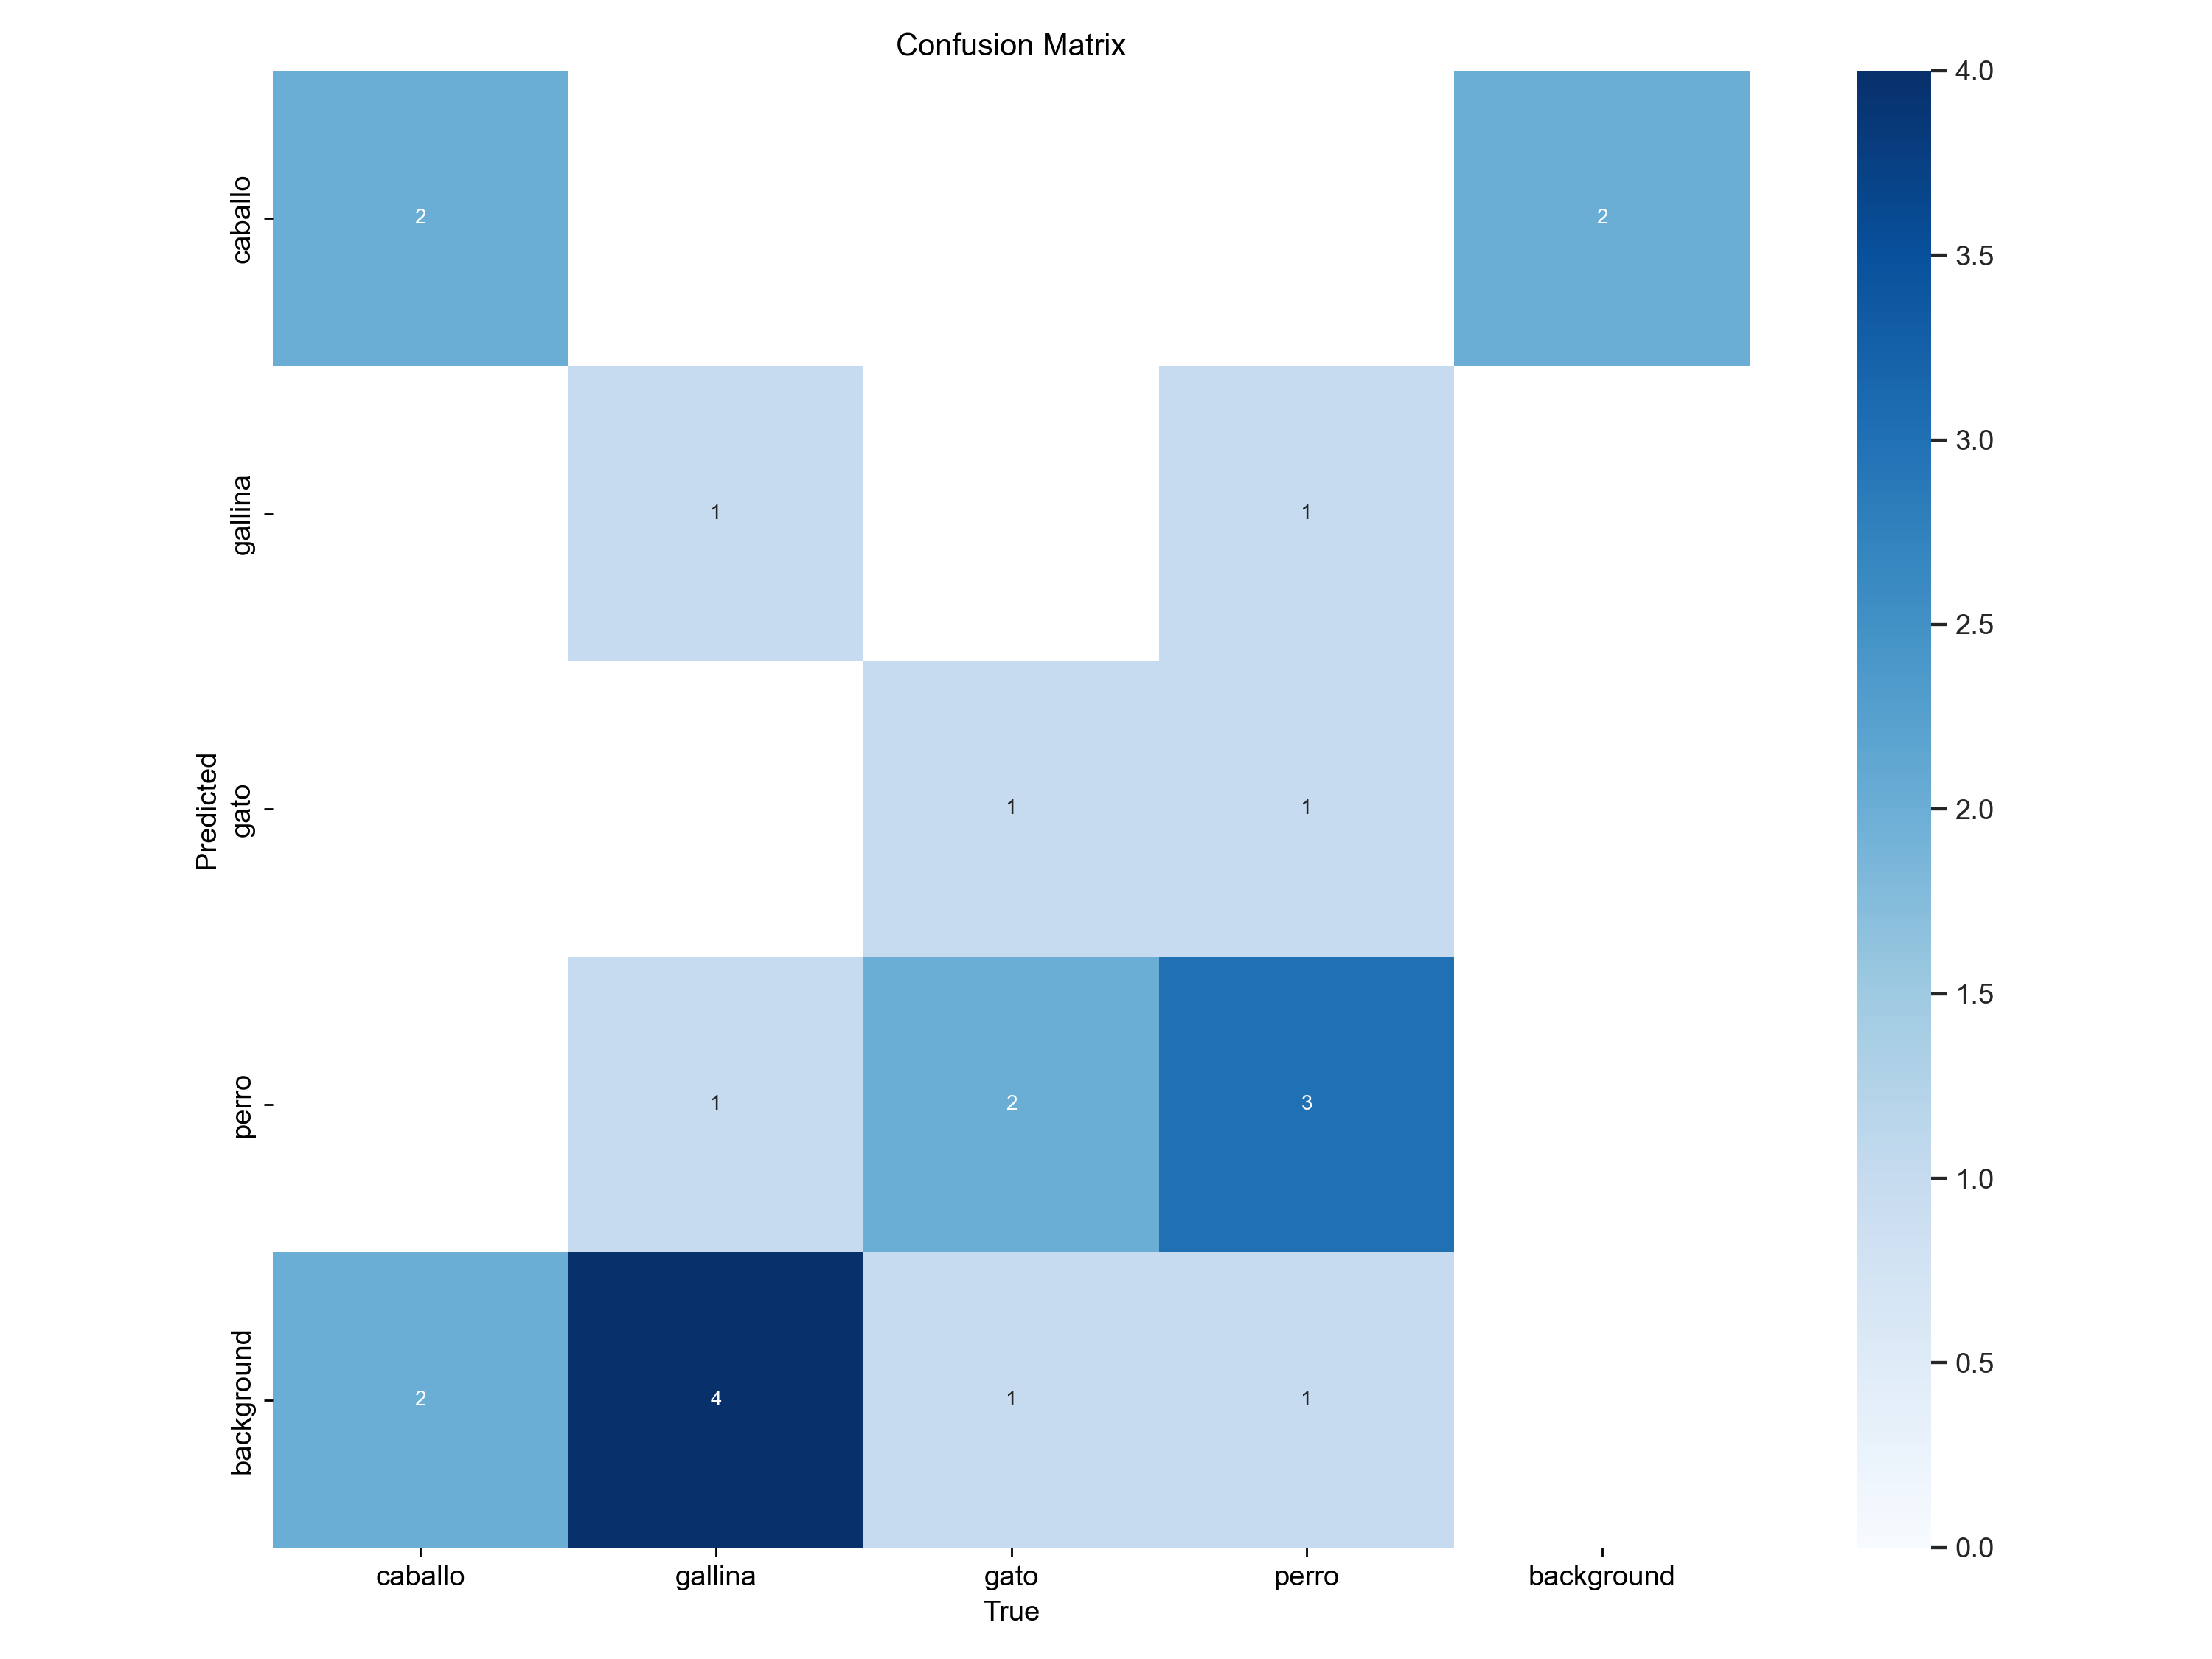

In [8]:
# Mostrar la matriz de confusión
Image(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

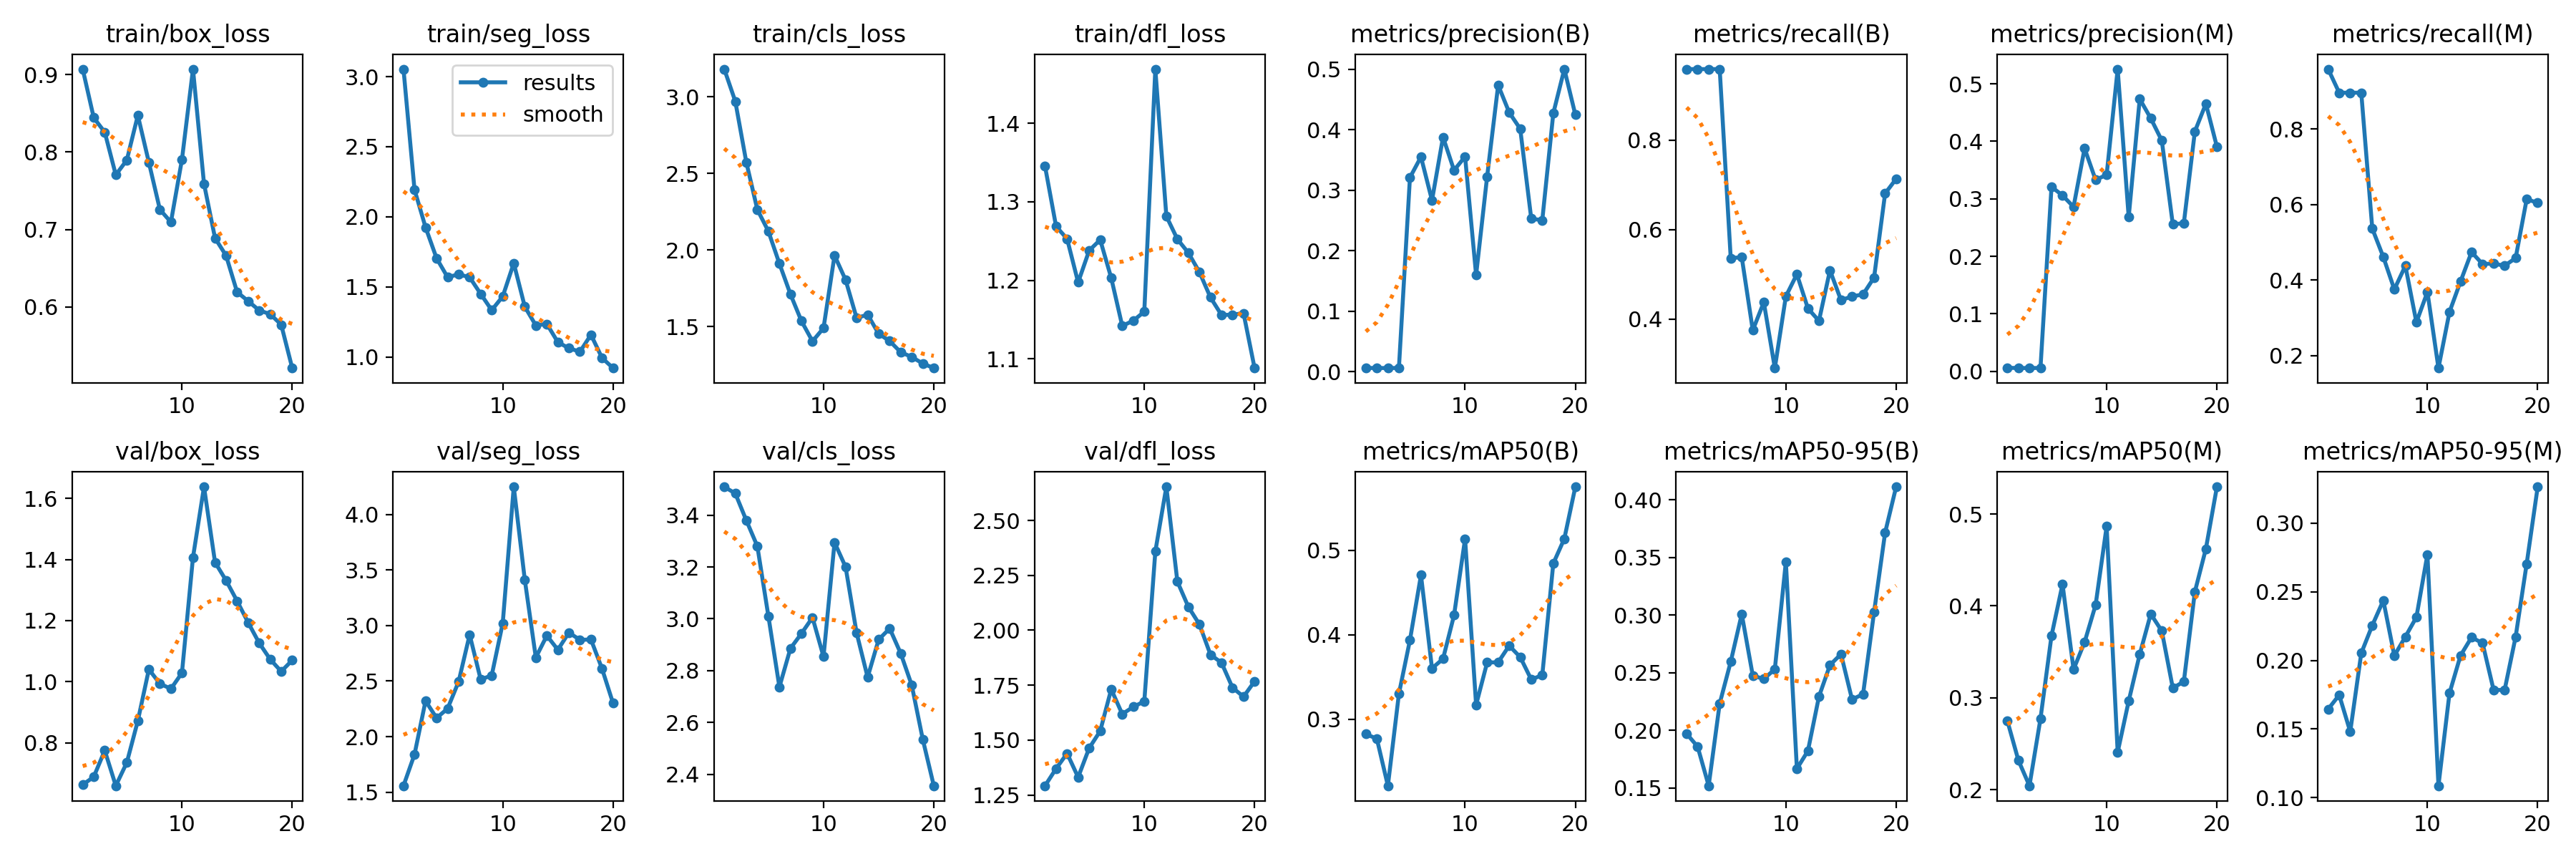

In [9]:
# Mostrar resultados de entrenamiento
Image(filename=f'{HOME}/runs/segment/train/results.png', width=600)

-Detección

In [3]:
!pip show opencv-python

Name: opencv-python
Version: 4.10.0.84
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: c:\Python312\Lib\site-packages
Requires: numpy
Required-by: ultralytics


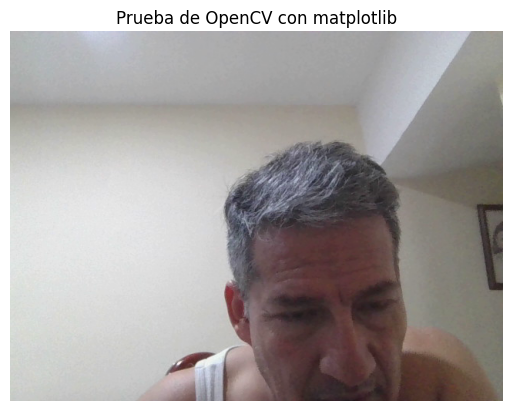

In [11]:
#Prueba de activación de la cámara

# Capturar video desde la cámara
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: No se pudo abrir la cámara.")
else:
    ret, frame = cap.read()
    if ret:
        # Convertir de BGR a RGB para matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Mostrar la imagen con matplotlib
        plt.imshow(frame_rgb)
        plt.title('Prueba de OpenCV con matplotlib')
        plt.axis('off')
        plt.show()
    else:
        print("Error: No se pudo capturar el frame.")

cap.release()


### Procesamiento clásico de Imagenes
Se realizan dos tipos de procesamiento de las imágenes al código anterior.
- Filtro de Detección de bordes (Sobel)
- Cambio de Color a Escala de Grises

In [1]:
#Instalamos la versión estándar de OpenCV, desinstalando OpenCV-python-headless
#!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [4]:
pip list | findstr opencv

opencv-python             4.10.0.84Note: you may need to restart the kernel to use updated packages.



In [5]:
#Obtención de segmentación en tiempo real

# Obtener la ruta actual de trabajo
HOME = os.getcwd()

# Cargar el modelo YOLOv8 previamente entrenado después del Data Augmentation
model_path = f"{HOME}/runs/segment/train/weights/best.pt"  # Asegúrate de que esta ruta es correcta
model = YOLO(model_path)

# Iniciar la captura de video desde la cámara (0 = cámara por defecto)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: No se pudo abrir la cámara.")
    exit()

# Configurar matplotlib para modo interactivo
plt.ion()
fig, ax = plt.subplots(figsize=(10, 6))

# Bucle para capturar video continuamente
while True:
    # Capturar un frame de la cámara
    ret, frame = cap.read()
    if not ret:
        print("Error: No se pudo capturar el frame.")
        break

    # Redimensionar el frame para garantizar un tamaño compatible con el modelo (por ejemplo, 640x640)
    resized_frame = cv2.resize(frame, (640, 640))

    # Realizar la predicción de segmentación
    results = model.predict(resized_frame, conf=0.25, iou=0.5, verbose=False)

    # Extraer la cantidad de instancias detectadas
    num_instances = len(results[0].boxes)
    print(f"Cantidad de instancias detectadas: {num_instances}")

    # Dibujar las segmentaciones en el frame
    annotated_frame = results[0].plot()

    # Mostrar el frame anotado con OpenCV
    cv2.imshow("Segmentación en Tiempo Real", annotated_frame)

    # Salir del bucle con la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar la cámara y cerrar las ventanas
cap.release()
cv2.destroyAllWindows()
plt.close()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
C